In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

### Prepare data

In [5]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [6]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [7]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [8]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [9]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [10]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [11]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [12]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

      fun: 3591517.6131855585
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.6409534 ,  -1.65561814,  -1.88506012,   7.15767357,
       -20.1317054 ,   9.15441812,  -3.50319481,  -1.58385777,
         1.77581452,   1.78097961,  17.68298653, -22.41144455,
       -11.35364142,  -3.23529737,   2.26936817,  -5.22488799,
        39.18851921,  -3.25739087])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 875
      nit: 756
   status: 0
  success: True
        x: array([ 1.11145934e+01,  1.59487581e+01, -1.29515154e+00, -4.19455553e+00,
        4.57195995e+00,  1.65017328e+01,  2.07570970e+01,  1.24439123e+02,
        1.01037072e+02, -7.75733956e-01, -2.86132718e+00, -2.45902409e+00,
       -1.56593987e-01,  7.76194273e-01,  2.91053143e-02, -2.79120855e+00,
       -2.46336887e+00,  4.62612732e-01])

### Predict on testing set

In [14]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_stddev = np.sqrt(standard_posterior_var) * train_tas_std

In [15]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_stddev, dims=tas_truth.dims, coords=tas_truth.coords)

In [16]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(tas_truth[-20:].mean(dim='time'), posterior_tas_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3301950767223535
RMSE at 2100: 0.3933661616474244
RMSE 2045-2055: 0.3498073396084103
RMSE 2090-2100: 0.42167416693305654
RMSE 2050-2100: 0.3731619632629697
RMSE average last 20y: 0.23641647865245521


[Text(0.5, 1.0, 'Difference')]

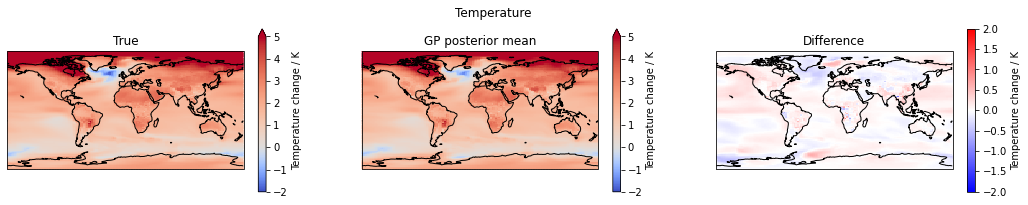

In [17]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [18]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.46261273]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,15.948758255179529
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,11.11460829309354
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.014964907546537285
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.24204880410848856
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.3786869308812617
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[4.58224456, 16.50173282, 20.75709699..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.0595388828243483
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.0556171, 0.08205763, 0.61791227..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0817170289703229


In [19]:
# Save predictions
posterior_tas_data.to_netcdf('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('climatebench-gp-posterior-std-tas-test-2019-2100.nc')